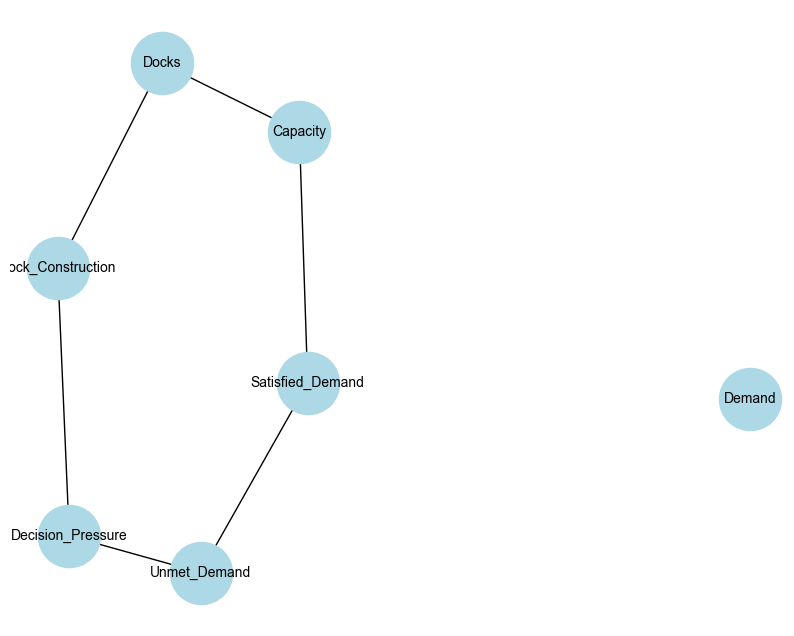

In [1]:
# Placeholder for a Python script that will generate a causal loop diagram using networkx and matplotlib.
# Run this script in a local Python environment.

import networkx as nx
import matplotlib.pyplot as plt

# Define variables and causal relationships
variables = [
    "Docks", "Demand", "Capacity", "Satisfied_Demand",
    "Unmet_Demand", "Decision_Pressure", "Dock_Construction"
]

edges = [
    ("Docks", "Capacity"),
    ("Capacity", "Satisfied_Demand"),
    ("Satisfied_Demand", "Unmet_Demand"),
    ("Unmet_Demand", "Decision_Pressure"),
    ("Decision_Pressure", "Dock_Construction"),
    ("Dock_Construction", "Docks")
]

# Create the graph
g = nx.DiGraph()
g.add_nodes_from(variables)
g.add_edges_from(edges)

# Draw the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(g, seed=42)
nx.draw_networkx_nodes(g, pos, node_color='lightblue', node_size=2000)
nx.draw_networkx_labels(g, pos, font_size=10)
nx.draw_networkx_edges(g, pos, arrowstyle='-|>', arrowsize=20)
plt.axis('off')
plt.show()


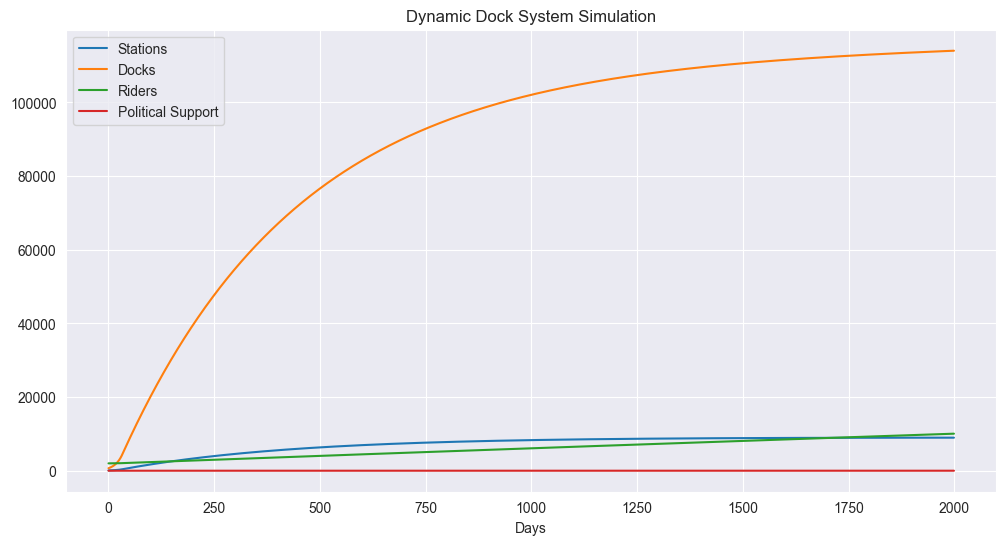

In [10]:
# Complex simulation of dock-only dynamics in Python
import numpy as np
import matplotlib.pyplot as plt

# Time horizon (in days)
T = 2000

time = np.arange(T)

# --- PARAMETERS ---
base_demand = 12000
turnover_per_dock = 5
alpha_service = 1.2
population = 5_000_000
adoption_rate = 0.00004
dropout_rate = 0.00009
support_gain_rate = 0.002
support_decay_rate = 0.0002
trips_half = 800
install_cost = 1000
subsidy_share = 0.3
closure_rate = 0.00008
retire_dock_rate = 0.00004
avg_docks_per_station = 12
invest_fraction0 = 0.1
fare = 1.4
op_cost_dock = 0.12
op_cost_station = 1.8

# --- INITIAL VALUES ---
Stations = np.zeros(T)
Docks = np.zeros(T)
Riders = np.zeros(T)
Support = np.zeros(T)

Stations[0] = 85
Docks[0] = 680
Riders[0] = 2000
Support[0] = 0.15

# --- SIMULATION LOOP ---
for t in range(T-1):
    # Service level
    service = min(1, (Docks[t] * turnover_per_dock) / (base_demand + 1e-9))

    # Demand response
    demand = base_demand * np.exp(alpha_service * (service - 0.5))
    supply = Docks[t] * turnover_per_dock
    trips = min(demand, supply)

    # Finance
    revenue = fare * trips 
    op_cost = op_cost_dock * Docks[t] + op_cost_station * Stations[t]
    profit = revenue - op_cost

    # Investment
    effective_cost = install_cost * (1 - subsidy_share)
    station_openings = max(0, invest_fraction * max(0, profit) / (effective_cost + 1e-9))
    station_closures = Stations[t] * closure_rate

    dock_install = station_openings * avg_docks_per_station
    dock_remove = Docks[t] * retire_dock_rate

    # Rider dynamics
    adoptions = adoption_rate * Riders[t] * (1 - Riders[t]/population) + 0.0002 * trips
    drop = dropout_rate * Riders[t]

    # Support dynamics
    support_gain = support_gain_rate * trips / (trips + trips_half)
    support_loss = support_decay_rate * Support[t]

    # Update stocks
    Stations[t+1] = Stations[t] + station_openings - station_closures
    Docks[t+1] = Docks[t] + dock_install - dock_remove
    Riders[t+1] = Riders[t] + adoptions - drop
    Support[t+1] = Support[t] + support_gain - support_loss

# --- Plot ---
plt.figure(figsize=(12,6))
plt.plot(time, Stations, label="Stations")
plt.plot(time, Docks, label="Docks")
plt.plot(time, Riders, label="Riders")
plt.plot(time, Support, label="Political Support")
plt.legend()
plt.xlabel("Days")
plt.title("Dynamic Dock System Simulation")
plt.grid(True)
plt.show()

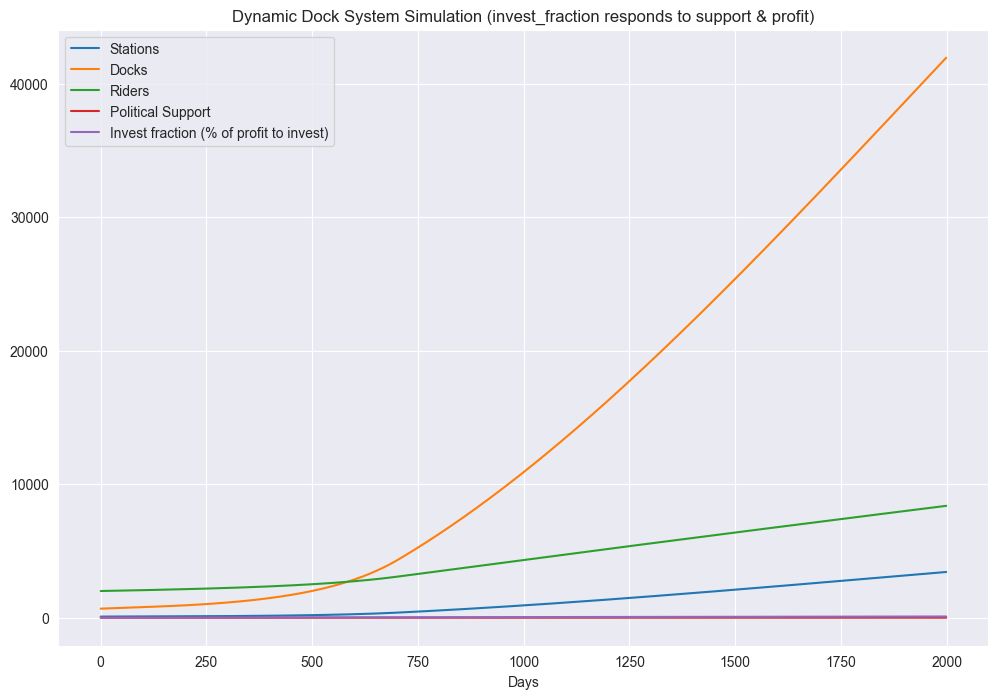

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Complex simulation of dock-only dynamics in Python
# Adds a dynamic rule for invest_fraction that depends on political support and recent profit

# Time horizon (in days)
T = 2000
time = np.arange(T)

# --- PARAMETERS ---
base_demand = 12000
turnover_per_dock = 5
alpha_service = 1.2
population = 5_000_000
adoption_rate = 0.00004
dropout_rate = 0.00009
support_gain_rate = 0.002
support_decay_rate = 0.0002
trips_half = 800
install_cost = 10000
subsidy_share = 0.3
closure_rate = 0.00008
retire_dock_rate = 0.00004
avg_docks_per_station = 12
fare = 1.4
op_cost_dock = 0.12
op_cost_station = 1.8

# --- INVEST FRACTION DYNAMICS PARAMETERS ---
# invest_fraction is the fraction of positive profit allocated to opening new stations.
# We let it evolve with political support and observed profitability.
support_to_invest_sensitivity = 0.3   # how strongly political support raises invest fraction
profit_to_invest_sensitivity = 1e-4   # how strongly profitability nudges invest fraction
invest_adjust_speed = 0.01            # daily adjustment speed (smaller -> slower change)
min_invest_fraction = 0.0
max_invest_fraction = 1.0

# --- INITIAL VALUES ---
Stations = np.zeros(T)
Docks = np.zeros(T)
Riders = np.zeros(T)
Support = np.zeros(T)
invest_fraction = np.zeros(T)

Stations[0] = 85
Docks[0] = 680
Riders[0] = 2000
Support[0] = 0.15
invest_fraction[0] = 0.10

# Keep a short memory of recent profit to smooth investment reaction
profit_memory = 0.0
profit_memory_alpha = 0.05  # smoothing parameter for profit memory

# --- SIMULATION LOOP ---
for t in range(T-1):
    # Service level (fraction of potential demand that can be turned into trips)
    service = min(1.0, (Docks[t] * turnover_per_dock) / (base_demand + 1e-9))

    # Demand response (elastic to service)
    demand = base_demand * np.exp(alpha_service * (service - 0.5))
    supply = Docks[t] * turnover_per_dock
    trips = min(demand, supply)

    # Finance
    revenue = fare * trips + subsidy_share * install_cost  # small per-period subsidy inflow
    op_cost = op_cost_dock * Docks[t] + op_cost_station * Stations[t]
    profit = revenue - op_cost

    # Smooth profit memory (so invest_fraction doesn't jitter on daily noise)
    profit_memory = (1 - profit_memory_alpha) * profit_memory + profit_memory_alpha * profit

    # Investment: station openings determined by fraction of (positive) profit divided by effective cost
    effective_cost = install_cost * (1 - subsidy_share)
    station_openings = 0.0
    if profit > 0:
        station_openings = invest_fraction[t] * profit / (effective_cost + 1e-9)
    station_closures = Stations[t] * closure_rate

    dock_install = station_openings * avg_docks_per_station
    dock_remove = Docks[t] * retire_dock_rate

    # Rider dynamics (simple logistic + trips-driven adoption)
    adoptions = adoption_rate * Riders[t] * (1 - Riders[t]/population) + 0.0002 * trips
    drop = dropout_rate * Riders[t]

    # Support dynamics (saturating gain from trips, linear decay)
    support_gain = support_gain_rate * trips / (trips + trips_half)
    support_loss = support_decay_rate * Support[t]

    # Update stocks
    Stations[t+1] = Stations[t] + station_openings - station_closures
    Docks[t+1] = Docks[t] + dock_install - dock_remove
    Riders[t+1] = max(0.0, Riders[t] + adoptions - drop)
    Support[t+1] = max(0.0, Support[t] + support_gain - support_loss)

    # --------- Dynamic invest_fraction rule ---------
    # Target invest_fraction is a bounded combination of political support and (smoothed) profit.
    # - support contributes a direct term (0..support_to_invest_sensitivity)
    # - profit contributes via scaling (profit_memory / effective_cost) * sensitivity
    # We then move the current invest_fraction toward the target at rate invest_adjust_speed.

    # compute profit signal (normalized by effective cost scale)
    profit_signal = 0.0
    if effective_cost > 0:
        profit_signal = profit_memory / (effective_cost + 1e-9)

    target_from_support = support_to_invest_sensitivity * Support[t+1]  # larger support -> higher target
    target_from_profit = profit_to_invest_sensitivity * max(0.0, profit_signal)

    invest_target = target_from_support + target_from_profit
    # bound target
    invest_target = max(min_invest_fraction, min(max_invest_fraction, invest_target))

    # adjust toward target smoothly
    invest_fraction[t+1] = invest_fraction[t] + invest_adjust_speed * (invest_target - invest_fraction[t])
    # ensure bounds
    invest_fraction[t+1] = max(min_invest_fraction, min(max_invest_fraction, invest_fraction[t+1]))

# --- Plot ---
plt.figure(figsize=(12,8))
plt.plot(time, Stations, label="Stations")
plt.plot(time, Docks, label="Docks")
plt.plot(time, Riders, label="Riders")
plt.plot(time, Support, label="Political Support")
plt.plot(time, invest_fraction * 100, label="Invest fraction (% of profit to invest)")
plt.legend()
plt.xlabel("Days")
plt.title("Dynamic Dock System Simulation (invest_fraction responds to support & profit)")
plt.grid(True)
plt.show()